In [1]:
import tensorflow as tf
import segmentation_models as sm
import glob
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
import keras 
import pandas as pd
from datetime import datetime 

from keras.utils import normalize
#from keras.metrics import MeanIoU


Segmentation Models: using `keras` framework.


In [2]:
#Resizing images, if needed
SIZE_X = 256 
SIZE_Y = 256
n_classes=4 #Number of classes for segmentation

#Capture training image info as a list
train_images = []


In [3]:
for directory_path in glob.glob("images/original_images/"):
    for img_path in glob.glob(os.path.join(directory_path, "*.png")):
        img = cv2.imread(img_path, 1)       
        img = cv2.resize(img, (SIZE_Y, SIZE_X))
        train_images.append(img)
    
#Convert list to array for machine learning processing        
train_images = np.array(train_images)

#Capture mask/label info as a list
train_masks = [] 
for directory_path in glob.glob("images/masked_images/"):
    for mask_path in glob.glob(os.path.join(directory_path, "*.png")):
        mask = cv2.imread(mask_path, 0)       
        mask = cv2.resize(mask, (SIZE_Y, SIZE_X), interpolation = cv2.INTER_NEAREST)  #Otherwise ground truth changes due to interpolation
        train_masks.append(mask)
        
#Convert list to array for machine learning processing          
train_masks = np.array(train_masks)

In [4]:
###############################################
#Encode labels... but multi dim array so need to flatten, encode and reshape
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w = train_masks.shape
train_masks_reshaped = train_masks.reshape(-1,1)
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)

np.unique(train_masks_encoded_original_shape)


/home/ankit/Desktop/ml/Tensorflow_ENV/tfenv/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0, 1, 2, 3])

In [5]:
#################################################
#train_images = np.expand_dims(train_images, axis=3)
#train_images = normalize(train_images, axis=1)

train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=3)

#Create a subset of data for quick testing
#Picking 10% for testing and remaining for training
from sklearn.model_selection import train_test_split
X1, X_test, y1, y_test = train_test_split(train_images, train_masks_input, test_size = 0.10, random_state = 0)

#Further split training data t a smaller subset for quick testing of models
X_train, X_do_not_use, y_train, y_do_not_use = train_test_split(X1, y1, test_size = 0.5, random_state = 0)

print("Class values in the dataset are ... ", np.unique(y_train))  # 0 is the background/few unlabeled 


Class values in the dataset are ...  [0 1 2 3]


In [6]:
from keras.utils import to_categorical
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))



test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))


In [7]:
######################################################
#Reused parameters in all models

n_classes=4
activation='softmax'

LR = 0.0001
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss (car: 1.; pedestrian: 2.; background: 0.5;)
dice_loss = sm.losses.DiceLoss(class_weights=np.array([0.25, 0.25, 0.25, 0.25])) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]


In [8]:
########################################################################

BACKBONE1 = 'resnet34'
preprocess_input1 = sm.get_preprocessing(BACKBONE1)

# preprocess input
X_train1 = preprocess_input1(X_train)
X_test1 = preprocess_input1(X_test)
#####################################################################


In [9]:
BACKBONE2 = 'inceptionv3'
preprocess_input2 = sm.get_preprocessing(BACKBONE2)

# preprocess input
X_train2 = preprocess_input2(X_train)
X_test2 = preprocess_input2(X_test)

In [10]:
BACKBONE3 = 'vgg16'
preprocess_input3 = sm.get_preprocessing(BACKBONE3)

# preprocess input
X_train3 = preprocess_input3(X_train)
X_test3 = preprocess_input3(X_test)

In [ ]:
from keras.models import load_model

#Set compile=False as we are not loading it for training, only for prediction.
model1 = load_model('res34_backbone_50epochs.hdf5', compile=False)
model2 = load_model('inceptionv3_backbone_50epochs.hdf5', compile=False)
model3 = load_model('vgg19_backbone_50epochs.hdf5', compile=False)


In [3]:
#Weighted average ensemble
models = [model1, model2, model3]
#preds = [model.predict(X_test) for model in models]

pred1 = model1.predict(X_test1)
pred2 = model2.predict(X_test2)
pred3 = model3.predict(X_test3)

preds=np.array([pred1, pred2, pred3])


NameError: name 'X_test1' is not defined

In [22]:
preds.shape

(3, 3, 128, 128, 4)

In [23]:
#preds=np.array(preds)
weights = [0.3, 0.5, 0.2]

#Use tensordot to sum the products of all elements over specified axes.
weighted_preds = np.tensordot(preds, weights, axes=((0),(0)))


In [24]:
weighted_preds.shape

(3, 128, 128, 4)

In [25]:
weighted_ensemble_prediction = np.argmax(weighted_preds, axis=3)

In [26]:
weighted_ensemble_prediction.shape

(3, 128, 128)

In [27]:
y_pred1_argmax=np.argmax(pred1, axis=3)
y_pred2_argmax=np.argmax(pred2, axis=3)
y_pred3_argmax=np.argmax(pred3, axis=3)

In [29]:
#Using built in keras function
from keras.metrics import MeanIoU
n_classes = 4
IOU1 = MeanIoU(num_classes=n_classes)  
IOU2 = MeanIoU(num_classes=n_classes)  
IOU3 = MeanIoU(num_classes=n_classes)  
IOU_weighted = MeanIoU(num_classes=n_classes)  

IOU1.update_state(y_test[:,:,:,0], y_pred1_argmax)
IOU2.update_state(y_test[:,:,:,0], y_pred2_argmax)
IOU3.update_state(y_test[:,:,:,0], y_pred3_argmax)
IOU_weighted.update_state(y_test[:,:,:,0], weighted_ensemble_prediction)


print('IOU Score for model1 = ', IOU1.result().numpy())
print('IOU Score for model2 = ', IOU2.result().numpy())
print('IOU Score for model3 = ', IOU3.result().numpy())
print('IOU Score for weighted average ensemble = ', IOU_weighted.result().numpy())
###########################################

IOU Score for model1 =  0.24954903
IOU Score for model2 =  0.5133823
IOU Score for model3 =  0.33288518
IOU Score for weighted average ensemble =  0.50420713


In [33]:
#Grid search for the best combination of w1, w2, w3 that gives maximum acuracy

import pandas as pd
df = pd.DataFrame([])

for w1 in range(0, 4):
    for w2 in range(0,4):
        for w3 in range(0,4):
            wts = [w1/10.,w2/10.,w3/10.]  
            IOU_wted = MeanIoU(num_classes=n_classes) 
            wted_preds = np.tensordot(preds, wts, axes=((0),(0)))
            wted_ensemble_pred = np.argmax(wted_preds, axis=3)
            IOU_wted.update_state(y_test[:,:,:,0], wted_ensemble_pred)
            print("Now predciting for weights :", w1/10., w2/10., w3/10., " : IOU = ", IOU_wted.result().numpy())
            df = pd.concat([df,pd.DataFrame({'wt1':wts[0],'wt2':wts[1],'wt3':wts[2], 'IOU': IOU_wted.result().numpy()}, index=[0])], ignore_index=True)
            
max_iou_row = df.iloc[df['IOU'].idxmax()]
print("Max IOU of ", max_iou_row[3], " obained with w1=", max_iou_row[0]," w2=", max_iou_row[1], " and w3=", max_iou_row[2])         

Now predciting for weights : 0.0 0.0 0.0  : IOU =  0.12232462
Now predciting for weights : 0.0 0.0 0.1  : IOU =  0.33288518
Now predciting for weights : 0.0 0.0 0.2  : IOU =  0.33288518
Now predciting for weights : 0.0 0.0 0.3  : IOU =  0.33288518
Now predciting for weights : 0.0 0.1 0.0  : IOU =  0.5133823
Now predciting for weights : 0.0 0.1 0.1  : IOU =  0.4988988
Now predciting for weights : 0.0 0.1 0.2  : IOU =  0.4520773
Now predciting for weights : 0.0 0.1 0.3  : IOU =  0.4144295
Now predciting for weights : 0.0 0.2 0.0  : IOU =  0.5133823
Now predciting for weights : 0.0 0.2 0.1  : IOU =  0.5126032
Now predciting for weights : 0.0 0.2 0.2  : IOU =  0.4988988
Now predciting for weights : 0.0 0.2 0.3  : IOU =  0.47709465
Now predciting for weights : 0.0 0.3 0.0  : IOU =  0.5133823
Now predciting for weights : 0.0 0.3 0.1  : IOU =  0.51410943
Now predciting for weights : 0.0 0.3 0.2  : IOU =  0.51009256
Now predciting for weights : 0.0 0.3 0.3  : IOU =  0.4988988
Now predciting fo

/tmp/ipykernel_27659/1213980429.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Max IOU of ", max_iou_row[3], " obained with w1=", max_iou_row[0]," w2=", max_iou_row[1], " and w3=", max_iou_row[2])


In [34]:
#############################################################
opt_weights = [max_iou_row[0], max_iou_row[1], max_iou_row[2]]

#Use tensordot to sum the products of all elements over specified axes.
opt_weighted_preds = np.tensordot(preds, opt_weights, axes=((0),(0)))
opt_weighted_ensemble_prediction = np.argmax(opt_weighted_preds, axis=3)
#######################################################

/tmp/ipykernel_27659/3907563457.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  opt_weights = [max_iou_row[0], max_iou_row[1], max_iou_row[2]]


In [40]:
#Predict on a few images

import random
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]

1/1 [==============================] - 0s 22ms/step


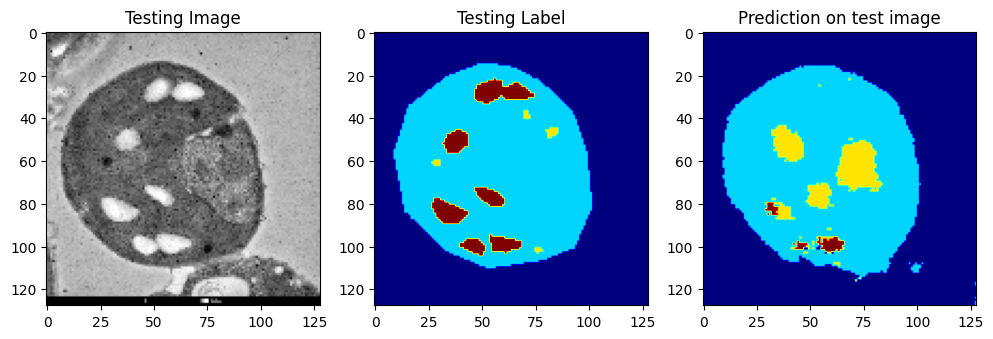

In [41]:
ground_truth=y_test[test_img_number]
test_img_norm=test_img[:,:,:]
test_img_input=np.expand_dims(test_img_norm, 0)

#Weighted average ensemble
models = [model1, model2, model3]

test_img_input1 = preprocess_input1(test_img_input)
test_img_input2 = preprocess_input2(test_img_input)
test_img_input3 = preprocess_input3(test_img_input)

test_pred1 = model1.predict(test_img_input1)
test_pred2 = model2.predict(test_img_input2)
test_pred3 = model3.predict(test_img_input3)

test_preds=np.array([test_pred1, test_pred2, test_pred3])

#Use tensordot to sum the products of all elements over specified axes.
weighted_test_preds = np.tensordot(test_preds, opt_weights, axes=((0),(0)))
weighted_ensemble_test_prediction = np.argmax(weighted_test_preds, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(weighted_ensemble_test_prediction, cmap='jet')
plt.show()

#####################################################################